In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow import keras

In [5]:
sys.path.append("../../../Scripts/")

In [6]:
import utils as gb_utils
import adversarial

In [7]:
# this is the setting for plots for research paper and articles.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
plt.rc('mathtext',**{'default':'regular'})

# Set the style for seaborn 
plt.style.use(['seaborn-white', 'seaborn-paper'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize': 'medium',
         'xtick.labelsize': 'small',
         'ytick.labelsize': 'small'
         }

pylab.rcParams.update(**params)

import seaborn as sns
sns.set_context(rc=params)

def stylize_axes(ax, title):
    # removes the top and right lines from the plot rectangle
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.xaxis.set_tick_params(top=False, direction='out', width=1)
    ax.yaxis.set_tick_params(right=False, direction='out', width=1)
    
    # Enforce the size of the title, label and tick labels
    #ax.set_xlabel(ax.get_xlabel(), fontsize='medium')
    #ax.set_ylabel(ax.get_ylabel(), fontsize='medium')
    
    #ax.set_yticklabels(ax.get_yticklabels(), fontsize='medium')
    #ax.set_xticklabels(fontsize='medium')
   
    ax.set_title(title)
    
def save_image(fig, title):
    if title is not None:
        fig.savefig('results/images/'+title+".png", dpi=300, bbox_inches='tight', transparent=True)
        fig.savefig('results/images/'+title+".pdf", bbox_inches='tight')

def figure_size(fig, size):
    fig.set_size_inches(size)
    fig.tight_layout()

In [9]:
images_result_path = "../Results/images/"
data_result_path = "../Results/texts/"
dataset_folder = "../Processed data/"

In [10]:
sns.set(font_scale=1.3, style="whitegrid")

In [11]:
os.listdir(dataset_folder)

['adl_activity_dataset_small.pickle',
 'adl_activity_dataset_small_minmax_scaled.pickle',
 'adl_activity_data_complete.pickle',
 'adl_activity_feature_dataset_small.pickle',
 'adl_dataset_small_minmax_scaled_feature.pickle',
 'adl_posture_dataset.pickle',
 'adl_posture_dataset_small.pickle',
 'adl_posture_data_complete.pickle',
 'adl_posture_feature_dataset.pickle',
 'adl_posture_feature_dataset_1.pickle',
 'DL_source_dataset.pickle',
 'DL_target_dataset.pickle',
 'mHealth_ankle_dataset.pickle',
 'mHealth_ankle_feature_dataset.pickle',
 'mHealth_chest_dataset.pickle',
 'mHealth_chest_feature_dataset.pickle',
 'mHealth_wrist_dataset.pickle',
 'mHealth_wrist_feature_dataset.pickle',
 'mHealth_wrist_feature_dataset_1.pickle',
 'mHealth_wrist_source_dataset.pickle',
 'mHealth_wrist_target_dataset.pickle',
 'uci_body_acc_dataset.pickle',
 'uci_feature_dataset.pickle',
 'uci_feature_dataset_1.pickle',
 'uci_source_dataset.pickle',
 'uci_target_dataset.pickle']

In [12]:
name = "uci_source_mhealth_target"

In [13]:
# load the source dataset
f = open(dataset_folder + "uci_body_acc_dataset.pickle", "rb")
uci_x, uci_y = pickle.load(f)
f.close()

In [16]:
uci_x.shape, np.unique(uci_y, return_counts=True)

((10299, 128, 3),
 (array([0, 1, 2, 3, 4, 5]),
  array([1722, 1544, 1406, 1777, 1906, 1944], dtype=int64)))

In [14]:
# load the target dataset
f = open(dataset_folder + "mHealth_wrist_dataset.pickle", "rb")
mhealth_x, mhealth_y = pickle.load(f)
f.close()

In [15]:
indexes = np.where(mhealth_y != 11)[0]
mhealth_x = mhealth_x[indexes]
mhealth_y = mhealth_y[indexes]

In [ ]:
mhealth_x.shape, np.unique()

In [8]:
n_channels = 3
n_window_length = 128

In [9]:
uci_features, uci_labels, uci_labels_one_hot = utils.get_features_labels_from_df(uci_df, n_channels, n_window_length)
mh_features, mh_labels, mh_labels_one_hot = utils.get_features_labels_from_df(mh_df, n_channels, n_window_length)

In [10]:
mh_n_classes = np.max(mh_labels) + 1
uci_n_classes = np.max(uci_labels) + 1

# We need to map the UCI labels to mhealth labels to evaluate the adversarial transferability

The mapping is given as, from UCI to MHEALTH

- Walking (0) --> Walking (3)
- Walking up (1) --> Climbing Stairs (4)
- Walking Down (2) --> Climbing Stairs (4)
- Sitting (3) --> Sitting (1)
- Standing (4) --> Standing (0)
- Lying (5) --> Lying (2)


For targeted case, the sitting class will be the target class. In uci dataset, sitting class has label 3 and in mhealth dataset the label is 1.

In [11]:
uci_mh_labels = []
for l in uci_labels:
    if l == 0:
        uci_mh_labels.append(3)
    elif l == 1:
        uci_mh_labels.append(4)
    elif l == 2:
        uci_mh_labels.append(4)
    elif l == 3:
        uci_mh_labels.append(1)
    elif l == 4:
        uci_mh_labels.append(0)
    elif l == 5: 
        uci_mh_labels.append(2)

In [12]:
uci_mh_labels_one_hot = keras.utils.to_categorical(uci_mh_labels, mh_n_classes)

# Train the UCI model :: the adversary has white box access to this model

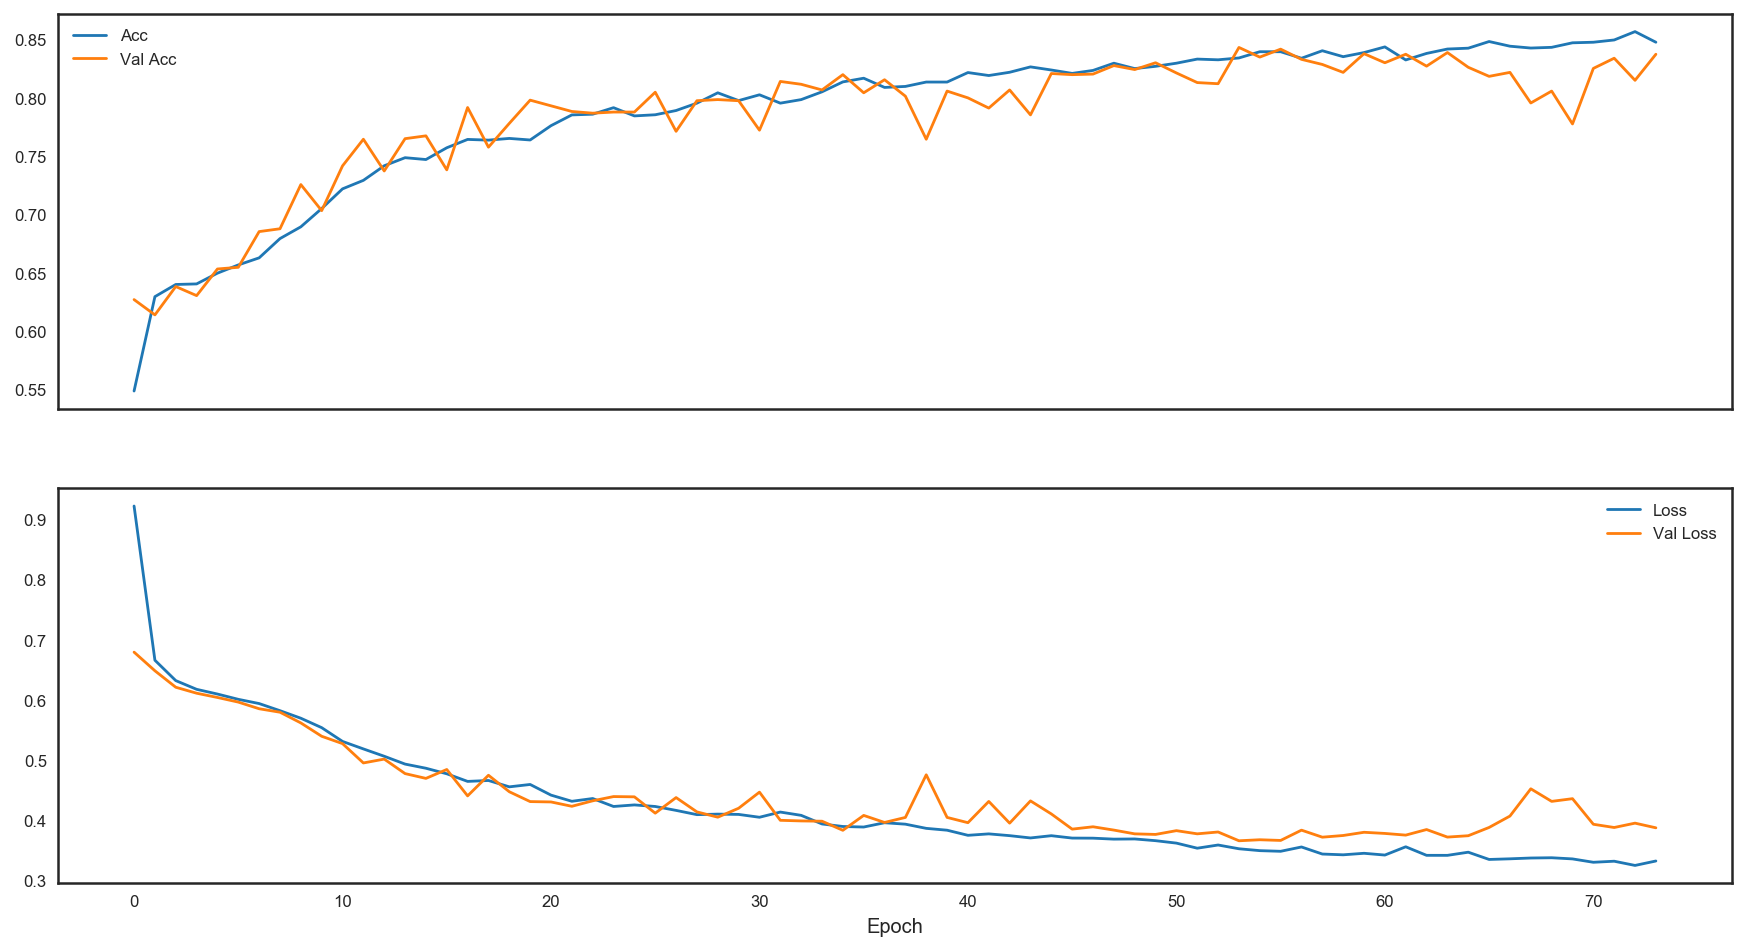

Epoch 00074: early stopping


In [17]:
uci_loss = utils.PlotLosses()
uci_early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, min_delta = 0.005, 
                                                 verbose = 1, mode='min')
uci_cbs = [uci_loss, uci_early_stop]
uci_model = utils.get_cnn_model((n_window_length, n_channels), uci_n_classes)

uci_history = uci_model.fit(uci_features, uci_labels_one_hot, batch_size = 32, epochs = 100, 
                               validation_split = 0.2, verbose = 0, callbacks = uci_cbs)

In [18]:
print("UCI Validation values, last epoch")
uci_history.history['val_loss'][-1], uci_history.history['val_acc'][-1] * 100

UCI Validation values, last epoch


(0.38669821721257513, 83.7378640660962)

In [19]:
print("UCI Training values, last epoch")
uci_history.history['loss'][-1], uci_history.history['acc'][-1] * 100

UCI Training values, last epoch


(0.3314145761744926, 84.76756888261218)

In [20]:
# we cannot evaluate the UCI model on the mhealth data, because of the differences between classes

In [21]:
keras.models.save_model(uci_model, "results/models/uci_body_cnn_model.h5py")

In [13]:
uci_model = keras.models.load_model("results/models/uci_body_cnn_model.h5py")

# Train the MHEALTH model

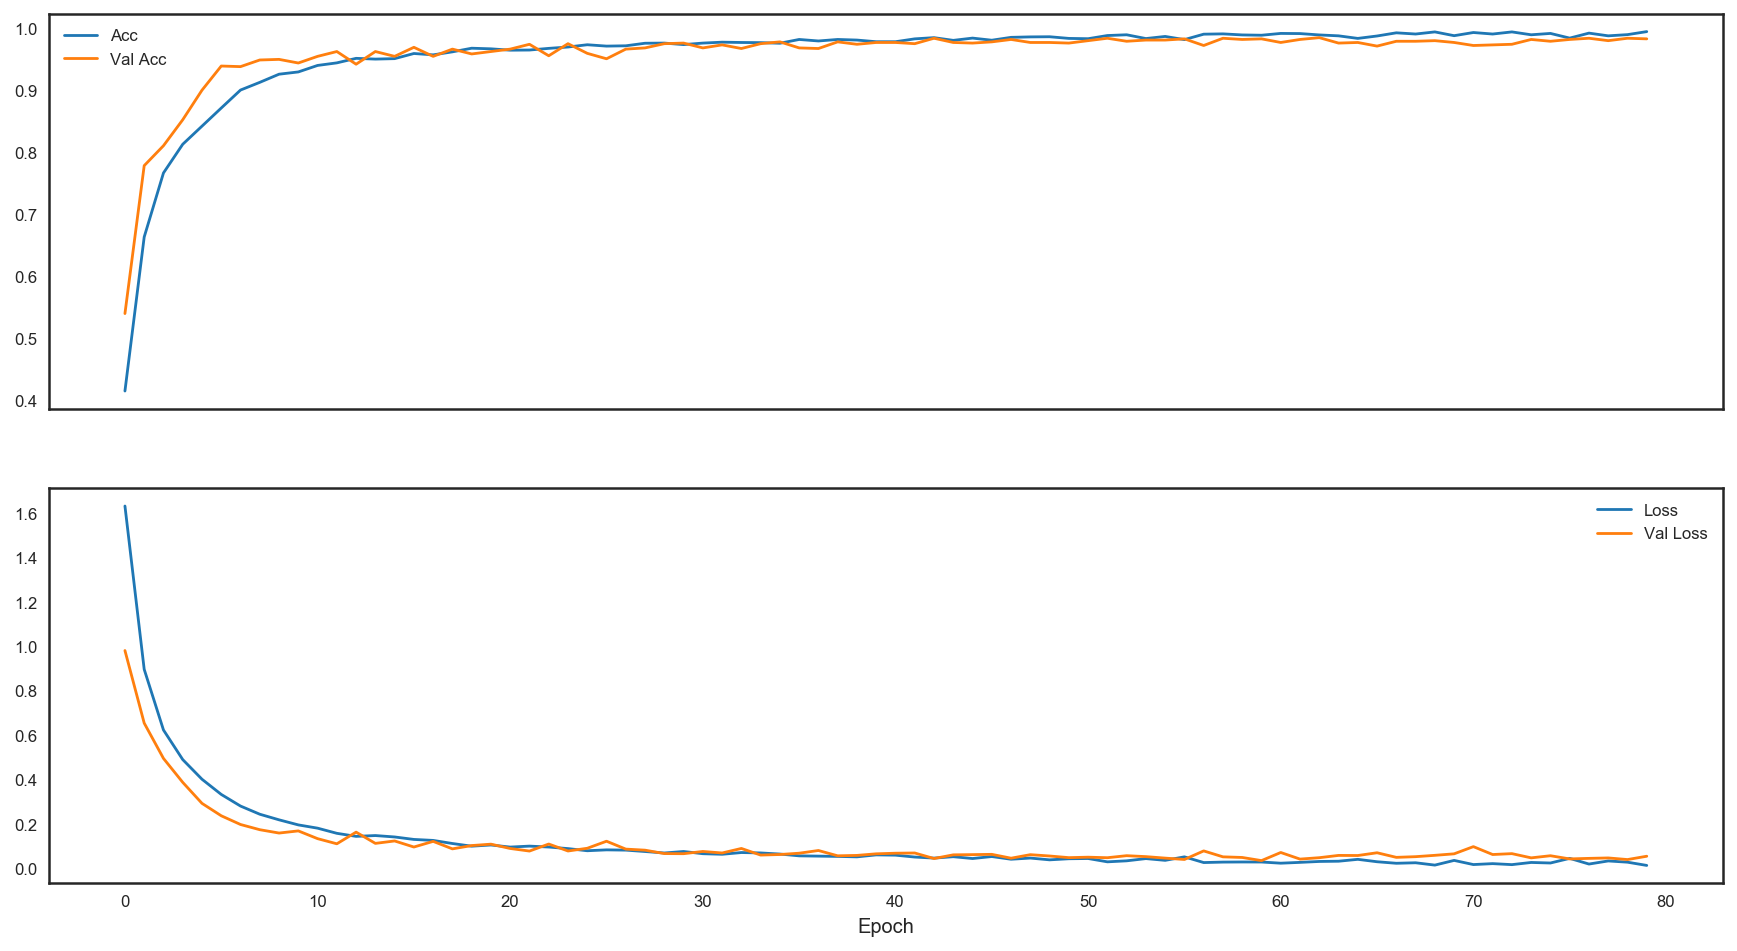

Epoch 00080: early stopping


In [23]:
mh_loss = utils.PlotLosses()
mh_early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, min_delta = 0.005, 
                                                 verbose = 1, mode='min')
mh_cbs = [mh_loss, mh_early_stop]
mh_model = utils.get_cnn_model((n_window_length, n_channels), mh_n_classes)

mh_history = mh_model.fit(mh_features, mh_labels_one_hot, batch_size = 32, epochs = 100, 
                               validation_split = 0.2, verbose = 0, callbacks = mh_cbs)

In [24]:
print("MHEALTH Validation values, last epoch")
mh_history.history['val_loss'][-1], mh_history.history['val_acc'][-1] * 100

MHEALTH Validation values, last epoch


(0.05509505209104618, 98.34469328140214)

In [25]:
print("MHEALTH Training values, last epoch")
mh_history.history['loss'][-1], mh_history.history['acc'][-1] * 100

MHEALTH Training values, last epoch


(0.013713931648720272, 99.51290793960058)

In [26]:
keras.models.save_model(mh_model, "results/models/mh_wrist_cnn_model.h5py")

In [14]:
mh_model = keras.models.load_model("results/models/mh_wrist_cnn_model.h5py")

In [15]:
# evalute the mhealth model on the uci dataset
mh_model.evaluate(uci_features, uci_mh_labels_one_hot)

10299/10299 [==============================] - 1s 104us/step


[12.565112203588207, 0.1901155452000098]

# Transferability

In [16]:
keras.backend.set_learning_phase(0)

In [10]:
epsilon = [0.1, 0.5, 0.9]
min_value = -1.0
max_value = 1.0
n_iterations = 50

## Untargeted Transferability

In [21]:
uci_untar_results = pd.DataFrame(columns=['Epsilon', "Attack Method", "Loss", "Accuracy"])
mh_untar_results = pd.DataFrame(columns=['Epsilon', "Attack Method", "Loss", "Accuracy"])

In [22]:
for eps in epsilon:
    # get the adversarial object for this value of epsilon
    uci_adv = adversarial.AdvesarialCompute(uci_model, min_value, max_value, n_iterations, eps)
    
    # compute the adversarial examples using the different methods
    fgsm_exm = uci_adv.fgsm_compute(uci_features, uci_labels_one_hot)
    
    biter_exm = uci_adv.basic_iter_compute(uci_features, uci_labels_one_hot)
    
    momentum_exm = uci_adv.momentum_iterative_compute(uci_features, uci_labels_one_hot)
    
    saliency_exm = uci_adv.saliency_compute(uci_features, uci_labels_one_hot)
    
    carlini_exm = uci_adv.carlini_compute(uci_features, uci_labels_one_hot)
    
    # evaluate the adversarial examples on the trained even and odd CNN model
    loss, acc = uci_model.evaluate(fgsm_exm, uci_labels_one_hot)
    uci_untar_results = uci_untar_results.append({"Epsilon": eps, "Attack Method": "FGSM", 
                                                         "Loss": loss, "Accuracy": acc * 100}, ignore_index = True)
    
    loss, acc = uci_model.evaluate(biter_exm, uci_labels_one_hot)
    uci_untar_results = uci_untar_results.append({"Epsilon": eps, "Attack Method": "BIM", 
                                                         "Loss": loss, "Accuracy": acc * 100}, ignore_index = True)
    
    loss, acc = uci_model.evaluate(momentum_exm, uci_labels_one_hot)
    uci_untar_results = uci_untar_results.append({"Epsilon": eps, "Attack Method": "MIM", 
                                                         "Loss": loss, "Accuracy": acc * 100}, ignore_index = True)
    
    loss, acc = uci_model.evaluate(saliency_exm, uci_labels_one_hot)
    uci_untar_results = uci_untar_results.append({"Epsilon": eps, "Attack Method": "SMM", 
                                                         "Loss": loss, "Accuracy": acc * 100}, ignore_index = True)
    
    loss, acc = uci_model.evaluate(carlini_exm, uci_labels_one_hot)
    uci_untar_results = uci_untar_results.append({"Epsilon": eps, "Attack Method": "CW", 
                                                         "Loss": loss, "Accuracy": acc * 100}, ignore_index = True)
    ##############################################################################################
    
    loss, acc = mh_model.evaluate(fgsm_exm, uci_mh_labels_one_hot)
    mh_untar_results = mh_untar_results.append({"Epsilon": eps, "Attack Method": "FGSM", 
                                                         "Loss": loss, "Accuracy": acc * 100}, ignore_index = True)
    
    loss, acc = mh_model.evaluate(biter_exm, uci_mh_labels_one_hot)
    mh_untar_results = mh_untar_results.append({"Epsilon": eps, "Attack Method": "BIM", 
                                                         "Loss": loss, "Accuracy": acc * 100}, ignore_index = True)
    
    loss, acc = mh_model.evaluate(momentum_exm, uci_mh_labels_one_hot)
    mh_untar_results = mh_untar_results.append({"Epsilon": eps, "Attack Method": "MIM", 
                                                         "Loss": loss, "Accuracy": acc * 100}, ignore_index = True)
    
    loss, acc = mh_model.evaluate(saliency_exm, uci_mh_labels_one_hot)
    mh_untar_results = mh_untar_results.append({"Epsilon": eps, "Attack Method": "SMM", 
                                                         "Loss": loss, "Accuracy": acc * 100}, ignore_index = True)
    
    loss, acc = mh_model.evaluate(carlini_exm, uci_mh_labels_one_hot)
    mh_untar_results = mh_untar_results.append({"Epsilon": eps, "Attack Method": "CW", 
                                                         "Loss": loss, "Accuracy": acc * 100}, ignore_index = True)
    

C:\Users\rames\Anaconda3\lib\site-packages\cleverhans\attacks_tf.py:26: UserWarning: attacks_tf is deprecated and will be removed on 2019-07-18 or after. Code should import functions from their new locations directly.
  warnings.warn("attacks_tf is deprecated and will be removed on 2019-07-18"
[INFO 2020-01-21 21:59:16,492 cleverhans] Constructing new graph for attack FastGradientMethod
[INFO 2020-01-21 21:59:18,218 cleverhans] Constructing new graph for attack BasicIterativeMethod
[INFO 2020-01-21 22:00:16,025 cleverhans] Constructing new graph for attack MomentumIterativeMethod
[INFO 2020-01-21 22:01:19,181 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-01-22 01:10:29,645 cleverhans] Constructing new graph for attack CarliniWagnerL2
C:\Users\rames\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\rames\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid 

10299/10299 [==============================] - 1s 93us/step


[INFO 2020-01-22 05:02:49,772 cleverhans] Constructing new graph for attack FastGradientMethod
[INFO 2020-01-22 05:02:51,590 cleverhans] Constructing new graph for attack BasicIterativeMethod
[INFO 2020-01-22 05:03:52,257 cleverhans] Constructing new graph for attack MomentumIterativeMethod
[INFO 2020-01-22 05:04:58,906 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-01-22 08:26:21,839 cleverhans] Constructing new graph for attack CarliniWagnerL2


10299/10299 [==============================] - 1s 88us/step


[INFO 2020-01-22 12:36:29,241 cleverhans] Constructing new graph for attack FastGradientMethod
[INFO 2020-01-22 12:36:31,109 cleverhans] Constructing new graph for attack BasicIterativeMethod
[INFO 2020-01-22 12:37:31,460 cleverhans] Constructing new graph for attack MomentumIterativeMethod
[INFO 2020-01-22 12:38:38,413 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-01-22 16:06:33,439 cleverhans] Constructing new graph for attack CarliniWagnerL2


10299/10299 [==============================] - 1s 90us/step


In [23]:
uci_untar_results.to_pickle("results/data/uci_untar_results_cross_dataset.pkl")
mh_untar_results.to_pickle("results/data/mh_untar_results_cross_dataset.pkl")

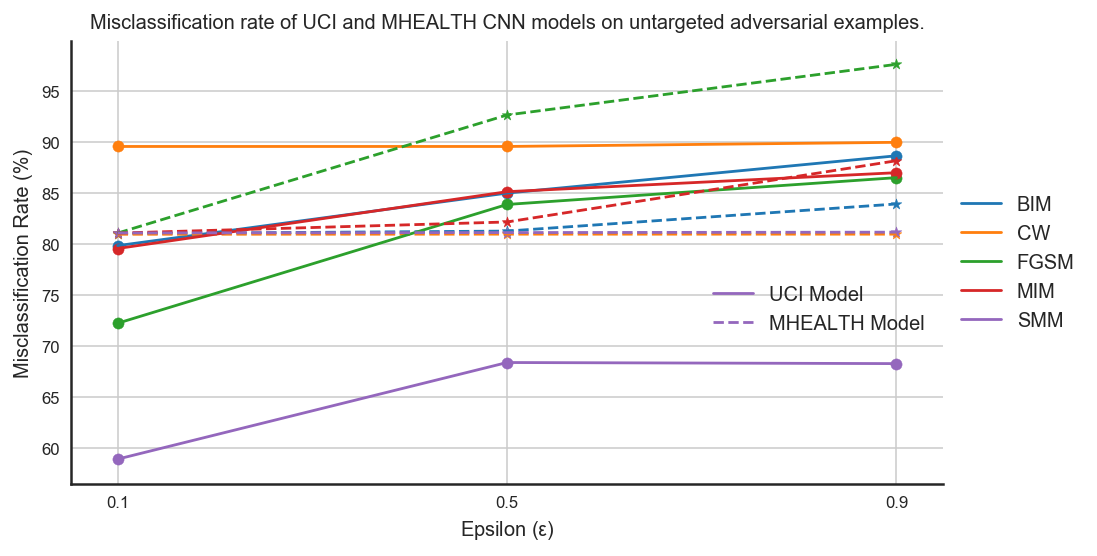

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for attack_type in np.unique(uci_untar_results['Attack Method'].values):
    # plot the even model values
    y = 100 - uci_untar_results[uci_untar_results['Attack Method'] == attack_type]['Accuracy'].values
    p = plt.plot(epsilon, y, label = attack_type)
    plt.scatter(epsilon, y, c = p[0].get_color())
    
    y = 100 - mh_untar_results[mh_untar_results['Attack Method'] == attack_type]['Accuracy'].values
    p1 = plt.plot(epsilon, y, linestyle='--', c = p[0].get_color())
    plt.scatter(epsilon, y, marker='*', c = p[0].get_color())

# put the xticks to the values of epsilon
plt.xticks(np.arange(0.1, 1.0, 0.4))

# put the xlabel and ylabel
plt.xlabel("Epsilon ($\epsilon$)")
plt.ylabel("Misclassification Rate (%)")

# stylize the axis and set the figure size
ax.grid()
stylize_axes(ax, "Misclassification rate of UCI and MHEALTH CNN models on untargeted adversarial examples.")
figure_size(fig, (7, 4))

# put the model legend in the top left corner
#p[0].set_color("#000000")
#p1[0].set_color('#000000')
legend1 = plt.legend([p[0], p1[0]], ["UCI Model", "MHEALTH Model"], loc='lower right', bbox_to_anchor=(1.0, 0.3), 
                     fontsize='medium')
plt.gca().add_artist(legend1)

# Shrink current axis by 40%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.99, box.height])

# Put the attack method legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

# save the image 
save_image(fig, "untar_ms_rate_cross_dataset")

# Targeted Adversarial Attack

In [20]:
# For targeted attack we need the target class labels
# The target class is the sitting class, label 3 for uci and 1 for mhealth
y_target_uci = np.ones(uci_labels.size) * 3
y_target_uci_one_hot = keras.utils.to_categorical(y_target_uci, uci_n_classes)

y_target_mh = np.ones(uci_labels.size) * 1
y_target_mh_one_hot = keras.utils.to_categorical(y_target_mh, mh_n_classes)

In [21]:
uci_tar_results = pd.DataFrame(columns=['Epsilon', "Attack Method", "Loss", "Accuracy", "Out Labels"])
mh_tar_results = pd.DataFrame(columns=['Epsilon', "Attack Method", "Loss", "Accuracy", "Out Labels"])

In [ ]:
for eps in epsilon:
    # get the adversarial object for this value of epsilon
    uci_adv = adversarial.AdvesarialCompute(uci_model, min_value, max_value, n_iterations, eps)
    
    # compute the adversarial examples using the different methods
    fgsm_exm = uci_adv.fgsm_compute(uci_features, uci_labels_one_hot, y_target_uci_one_hot)
    
    biter_exm = uci_adv.basic_iter_compute(uci_features, uci_labels_one_hot, y_target_uci_one_hot)
    
    momentum_exm = uci_adv.momentum_iterative_compute(uci_features, uci_labels_one_hot, y_target_uci_one_hot)
    
    saliency_exm = uci_adv.saliency_compute(uci_features, uci_labels_one_hot, y_target_uci_one_hot)
    
    carlini_exm = uci_adv.carlini_compute(uci_features, uci_labels_one_hot, y_target_uci_one_hot)
    
    # evaluate the adversarial examples on the trained even and odd CNN model
    loss, acc = uci_model.evaluate(fgsm_exm, y_target_uci_one_hot)
    labels = np.argmax(uci_model.predict(fgsm_exm), axis = 1)
    uci_tar_results = uci_tar_results.append({"Epsilon": eps, "Attack Method": "FGSM", 
                                                         "Loss": loss, "Accuracy": acc * 100,
                                             "Out Labels": labels}, ignore_index = True)
    
    loss, acc = uci_model.evaluate(biter_exm, y_target_uci_one_hot)
    labels = np.argmax(uci_model.predict(biter_exm), axis = 1)
    uci_tar_results = uci_tar_results.append({"Epsilon": eps, "Attack Method": "BIM", 
                                                         "Loss": loss, "Accuracy": acc * 100,
                                             "Out Labels": labels}, ignore_index = True)
    
    loss, acc = uci_model.evaluate(momentum_exm, y_target_uci_one_hot)
    labels = np.argmax(uci_model.predict(momentum_exm), axis = 1)
    uci_tar_results = uci_tar_results.append({"Epsilon": eps, "Attack Method": "MIM", 
                                                         "Loss": loss, "Accuracy": acc * 100,
                                             "Out Labels": labels}, ignore_index = True)
    
    loss, acc = uci_model.evaluate(saliency_exm, y_target_uci_one_hot)
    labels = np.argmax(uci_model.predict(saliency_exm), axis = 1)
    uci_tar_results = uci_tar_results.append({"Epsilon": eps, "Attack Method": "SMM", 
                                                         "Loss": loss, "Accuracy": acc * 100,
                                             "Out Labels": labels}, ignore_index = True)
    
    loss, acc = uci_model.evaluate(carlini_exm, y_target_uci_one_hot)
    labels = np.argmax(uci_model.predict(carlini_exm), axis = 1)
    uci_tar_results = uci_tar_results.append({"Epsilon": eps, "Attack Method": "CW", 
                                                         "Loss": loss, "Accuracy": acc * 100,
                                             "Out Labels": labels}, ignore_index = True)
    ##############################################################################################
    
    loss, acc = mh_model.evaluate(fgsm_exm, y_target_mh_one_hot)
    labels = np.argmax(mh_model.predict(fgsm_exm), axis = 1)
    mh_tar_results = mh_tar_results.append({"Epsilon": eps, "Attack Method": "FGSM", 
                                                         "Loss": loss, "Accuracy": acc * 100,
                                           "Out Labels": labels}, ignore_index = True)
    
    loss, acc = mh_model.evaluate(biter_exm, y_target_mh_one_hot)
    labels = np.argmax(mh_model.predict(biter_exm), axis = 1)
    mh_tar_results = mh_tar_results.append({"Epsilon": eps, "Attack Method": "BIM", 
                                                         "Loss": loss, "Accuracy": acc * 100,
                                           "Out Labels": labels}, ignore_index = True)
    
    loss, acc = mh_model.evaluate(momentum_exm, y_target_mh_one_hot)
    labels = np.argmax(mh_model.predict(momentum_exm), axis = 1)
    mh_tar_results = mh_tar_results.append({"Epsilon": eps, "Attack Method": "MIM", 
                                                         "Loss": loss, "Accuracy": acc * 100,
                                           "Out Labels": labels}, ignore_index = True)
    
    loss, acc = mh_model.evaluate(saliency_exm, y_target_mh_one_hot)
    labels = np.argmax(mh_model.predict(saliency_exm), axis = 1)
    mh_tar_results = mh_tar_results.append({"Epsilon": eps, "Attack Method": "SMM", 
                                                         "Loss": loss, "Accuracy": acc * 100,
                                           "Out Labels": labels}, ignore_index = True)
    
    loss, acc = mh_model.evaluate(carlini_exm, y_target_mh_one_hot)
    labels = np.argmax(mh_model.predict(carlini_exm), axis = 1)
    mh_tar_results = mh_tar_results.append({"Epsilon": eps, "Attack Method": "CW", 
                                                         "Loss": loss, "Accuracy": acc * 100,
                                           "Out Labels": labels}, ignore_index = True)
    

[INFO 2020-01-25 09:11:36,191 cleverhans] Constructing new graph for attack FastGradientMethod
[INFO 2020-01-25 09:11:37,768 cleverhans] Constructing new graph for attack BasicIterativeMethod
[INFO 2020-01-25 09:12:40,108 cleverhans] Constructing new graph for attack MomentumIterativeMethod
[INFO 2020-01-25 09:13:46,470 cleverhans] Constructing new graph for attack SaliencyMapMethod


In [ ]:
uci_tar_results.to_pickle("results/data/uci_tar_results_cross_dataset.pkl")
mh_tar_results.to_pickle("results/data/mh_tar_results_cross_dataset.pkl")

In [7]:
file = open("results/data/uci_tar_results_cross_dataset.pkl", "rb")
uci_tar_results = pickle.load(file)
file.close()

file = open("results/data/mh_tar_results_cross_dataset.pkl", "rb")
mh_tar_results = pickle.load(file)
file.close()

In [15]:
uci_tar_results

,Epsilon,Attack Method,Loss,Accuracy,Out Labels
0,0.1,FGSM,8.950427e+00,21.070007,"[3, 3, 3, 2, 2, 5, 5, 0, 2, 2, 5, 2, 2, 5, 0, ..."
1,0.1,BIM,3.137257e+00,69.171764,"[3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 1, ..."
2,0.1,MIM,3.961953e+00,63.142053,"[3, 3, 3, 2, 2, 3, 3, 1, 2, 2, 3, 2, 2, 3, 1, ..."
3,0.1,SMM,6.574174e+00,55.995728,"[3, 3, 0, 2, 0, 3, 3, 2, 2, 0, 3, 2, 2, 3, 0, ..."
4,0.1,CW,7.188281e-01,100.000000,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
5,0.5,FGSM,1.229311e+01,11.379746,"[2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, ..."
6,0.5,BIM,2.210596e-02,99.446548,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
7,0.5,MIM,2.824465e-04,99.990290,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
8,0.5,SMM,4.182893e+00,75.822895,"[3, 3, 3, 2, 0, 3, 3, 3, 2, 0, 3, 2, 2, 3, 0, ..."
9,0.5,CW,5.621250e-01,100.000000,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."


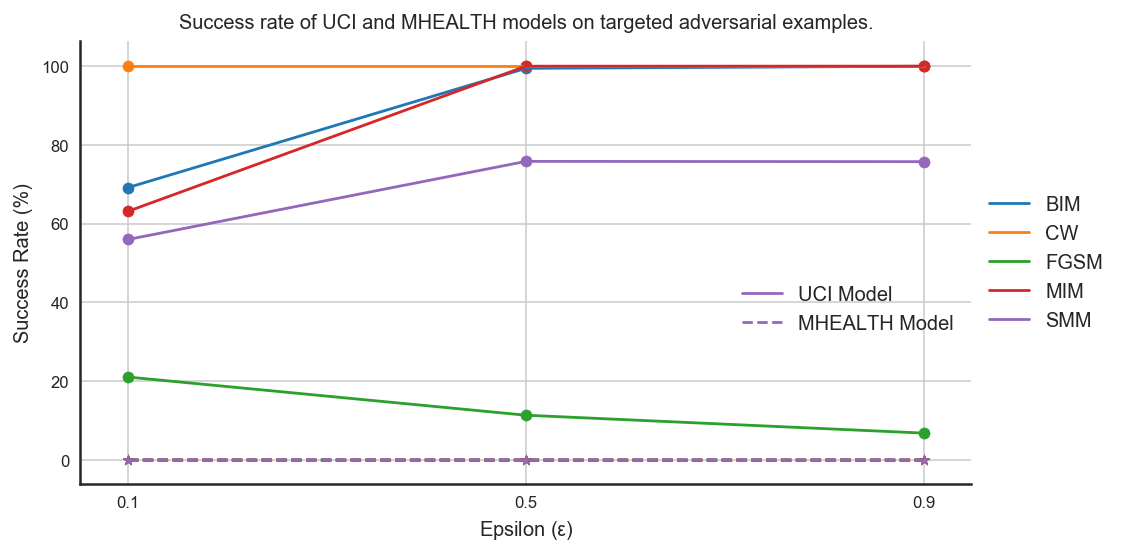

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for attack_type in np.unique(uci_tar_results['Attack Method'].values):
    
    y = uci_tar_results[uci_tar_results['Attack Method'] == attack_type]['Accuracy'].values
    p = plt.plot(epsilon, y, label = attack_type)
    plt.scatter(epsilon, y, c = p[0].get_color())
    
    y = mh_tar_results[mh_tar_results['Attack Method'] == attack_type]['Accuracy'].values
    p1 = plt.plot(epsilon, y, linestyle='--', c = p[0].get_color())
    plt.scatter(epsilon, y, marker='*', c = p[0].get_color())

# put the xticks to the values of epsilon
plt.xticks(np.arange(0.1, 1.0, 0.4))

# put the xlabel and ylabel
plt.xlabel("Epsilon ($\epsilon$)")
plt.ylabel("Success Rate (%)")

# stylize the axis and set the figure size
ax.grid()
stylize_axes(ax, "Success rate of UCI and MHEALTH models on targeted adversarial examples.")
figure_size(fig, (7, 4))

# put the model legend in the top left corner
#p[0].set_color("#000000")
#p1[0].set_color('#000000')
legend1 = plt.legend([p[0], p1[0]], ["UCI Model", "MHEALTH Model"], loc='lower right', bbox_to_anchor=(1.0, 0.3), 
                     fontsize='medium')
plt.gca().add_artist(legend1)

# Shrink current axis by 40%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.99, box.height])

# Put the attack method legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

# save the image 
save_image(fig, "tar_success_rate_cross_dataset")